<a href="https://colab.research.google.com/github/Jeongyeon-Myeong/Python-Project/blob/master/BERT_%EC%98%81%EC%96%B4_friends_%EB%8D%B0%EC%9D%B4%ED%84%B0_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preparation**

- Edit > Notebook settings > Hardward accelerators > GPU > SAVE
- Download the Friends dataset in EmotionLines website:
http://doraemon.iis.sinica.edu.tw/emotionlines/download.html
- Download the unlabeled json file.

# **Tutorials**

##### **Settings**

In [1]:
!pip install transformers --quiet # package installer for python

     |████████████████████████████████| 1.5MB 13.6MB/s 
     |████████████████████████████████| 890kB 57.5MB/s 
     |████████████████████████████████| 2.9MB 51.9MB/s 


In [2]:
import torch
from transformers import BertModel, BertTokenizer

In [3]:
pretrained_weights = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pretrained_weights) #bert tokenizer
model = BertModel.from_pretrained(pretrained_weights) # bert model

##### **Tokenization**

In [4]:
#예시 문장
sentence = 'Mark, All the classes are provided.'

In [5]:
 #bert tokenizer로 토큰화
tokens = tokenizer.tokenize(sentence) #['[CLS]', 'all', 'the', 'classes', 'are', 'provided', '.', '[SEP]']
tokens = ['[CLS]'] + tokens + ['[SEP]']
print(tokens)

['[CLS]', 'mark', ',', 'all', 'the', 'classes', 'are', 'provided', '.', '[SEP]']


In [6]:
# token하여 id로 바꾼다.[[101, 2035, 1996, 4280, 2024, 3024, 1012, 102]]
#Converts a token string (or a sequence of tokens) in a single integer id (or a sequence of ids), using the vocabulary.
ids = [tokenizer.convert_tokens_to_ids(tokens)]
print(ids)

[[101, 2928, 1010, 2035, 1996, 4280, 2024, 3024, 1012, 102]]


In [7]:
ids = [[101, 2928, 1010, 2035, 1996, 4280, 2024, 3024, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
attention_masks = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [8]:
#tensor로 변경, tensor([[ 101, 2035, 1996, 4280, 2024, 3024, 1012,  102]])
input_tensor = torch.tensor(ids)
masks_tensor = torch.tensor(attention_masks)

In [9]:
print(masks_tensor.size())

torch.Size([1, 19])


##### **Model**

In [ ]:
# id값을 bert모델에 넣기
hidden_tensor = model(input_tensor, attention_mask = masks_tensor)[0]
print(hidden_tensor.size())

torch.Size([1, 19, 768])


In [ ]:
hidden_tensor

tensor([[[-0.3332,  0.3654,  0.1161,  ..., -0.1596,  0.2420,  0.5352],
         [ 0.5816,  0.3318,  0.3934,  ...,  0.2164,  0.3406, -0.2485],
         [-0.0190,  0.4895,  0.4740,  ..., -0.3352,  0.3113,  0.3196],
         ...,
         [ 0.1850,  0.4164,  0.4646,  ...,  0.0479, -0.0294, -0.1171],
         [ 0.3209,  0.3451,  0.4535,  ...,  0.0429, -0.0533, -0.0560],
         [ 0.3667,  0.3243,  0.4432,  ...,  0.0751, -0.0630, -0.0889]]],
       grad_fn=<NativeLayerNormBackward>)

In [ ]:
#torch.Size([1, 8, 768])
logit = torch.nn.Linear(768, 2)(hidden_tensor)
print(logit.size())
print(logit.data)

torch.Size([1, 19, 2])
tensor([[[-0.0394, -0.6272],
         [ 0.2332, -0.5167],
         [ 0.0976,  0.0890],
         [-0.2424, -0.4108],
         [-0.0234, -0.1241],
         [-0.0410, -0.3244],
         [ 0.0504, -0.0833],
         [-0.0383,  0.0512],
         [ 0.2636, -0.4400],
         [ 0.4942, -0.0908],
         [ 0.3496, -0.3235],
         [ 0.5387, -0.3592],
         [ 0.2215, -0.2635],
         [ 0.6073, -0.4124],
         [ 0.4209, -0.2905],
         [ 0.1868, -0.2592],
         [ 0.2577, -0.2580],
         [ 0.1927, -0.2361],
         [ 0.1884, -0.2572]]])


In [ ]:
prediction = torch.nn.Softmax(dim=-1)(logit)
print(prediction.size())
print(prediction.data)

torch.Size([1, 19, 2])
tensor([[[0.6429, 0.3571],
         [0.6792, 0.3208],
         [0.5021, 0.4979],
         [0.5420, 0.4580],
         [0.5252, 0.4748],
         [0.5704, 0.4296],
         [0.5334, 0.4666],
         [0.4777, 0.5223],
         [0.6690, 0.3310],
         [0.6422, 0.3578],
         [0.6622, 0.3378],
         [0.7105, 0.2895],
         [0.6189, 0.3811],
         [0.7349, 0.2651],
         [0.6707, 0.3293],
         [0.6097, 0.3903],
         [0.6262, 0.3738],
         [0.6056, 0.3944],
         [0.6096, 0.3904]]])


# **Emotion Recognition**

**Train and Dev Dataset**

In [ ]:
import os
print(os.getcwd())

/content


In [4]:
import json

data = {'train': {'speaker': [], 'utterance': [], 'emotion': []},
        'dev': {'speaker': [], 'utterance': [], 'emotion': []},
        'test': {'speaker': [], 'utterance': [], 'emotion': []}}

for dtype in ['train', 'dev', 'test']:
  for dialog in json.loads(open('friends_' + dtype + '.json').read()):
    for line in dialog:
      data[dtype]['speaker'].append(line['speaker'])
      data[dtype]['utterance'].append(line['utterance'])
      data[dtype]['emotion'].append(line['emotion'])

In [5]:
# index 고정
i2e_dict = {'joy':0,
 'surprise':1,
 'non-neutral':2,
 'sadness':3,
 'disgust':4,
 'fear':5,
 'anger':6,
 'neutral':7}

In [6]:
i2e_dict_change = {0: 'joy',
1:'surprise',
2:'non-neutral',
3:'sadness',
4:'disgust',
5:'fear',
6:'anger',
7:'neutral'}

In [7]:
weights = [data['train']['emotion'].count('joy'),
          data['train']['emotion'].count('surprise'),
          data['train']['emotion'].count('non-neutral'),
          data['train']['emotion'].count('sadness'),
          data['train']['emotion'].count('disgust'),
          data['train']['emotion'].count('fear'),
          data['train']['emotion'].count('anger'),
          data['train']['emotion'].count('neutral')]
weights = [ max(weights) /num for num in weights]

In [8]:
weights

[3.7038191738113797,
 3.8950819672131147,
 2.3559742191373325,
 13.538461538461538,
 19.8,
 25.686486486486487,
 9.263157894736842,
 1.0]

            "speaker": "The Interviewer",
            "utterance": "You must\u0092ve had your hands full.",
            "emotion": "neutral",
            "annotation": "5000000"

In [9]:
import pandas as pd
# train/ dev/ test 셋으로 나눔
friendsdata_train_dict = data['train']
friendsdata_dev_dict = data['dev']
friendsdata_test_dict = data['test']

# 이해하기 쉽게 dataframe형태로 우선 변경
friends_traindata = pd.DataFrame(friendsdata_train_dict)
friends_devdata = pd.DataFrame(friendsdata_dev_dict)
friends_testdata = pd.DataFrame(friendsdata_test_dict)

In [10]:
# dataframe을 list형태로 변경함.
train_utterance = friends_traindata['utterance'].values.tolist()
dev_utterance = friends_devdata['utterance'].values.tolist()
train_emotion = friends_traindata['emotion'].values.tolist()
dev_emotion = friends_devdata['emotion'].values.tolist()
train_speaker = friends_traindata['speaker'].values.tolist()
dev_speaker = friends_devdata['speaker'].values.tolist()

In [11]:
train_utterance_copy = train_utterance.copy()
dev_utterance_copy = dev_utterance.copy()

In [12]:
#train_utterance
#train_speaker
def token_input(utterance, utterance_copy, speaker ):
  for i in range(len(utterance)):
    if ( i > 0 and speaker[i-1] == speaker[i]):
      utterance[i] = '[CLS] ' + speaker[i] + ', ' + utterance_copy[i] + ' [SEP] ' + utterance_copy[i-1] + ' [SEP] [PAD]' 
    else:
      utterance[i] = '[CLS] ' + speaker[i] + ', ' + utterance_copy[i] + ' [SEP] [PAD]' 

In [13]:
token_input(train_utterance, train_utterance_copy, train_speaker)
token_input(dev_utterance, dev_utterance_copy, dev_speaker)

In [ ]:
# train과 dev dataset 
"""
for i in range(len(train_utterance)):
   train_utterance[i] = train_speaker[i] + ', ' + train_utterance[i]
for i in range(len(dev_utterance)):
   dev_utterance[i] = dev_speaker[i] + ', ' + dev_utterance[i]   
"""

리뷰의 최대 길이 : 402
리뷰의 평균 길이 : 75.43168260581385


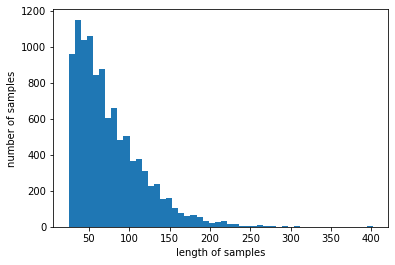

In [14]:
import matplotlib.pyplot as plt
print('리뷰의 최대 길이 :',max(len(l) for l in train_utterance))
print('리뷰의 평균 길이 :',sum(map(len, train_utterance))/len(train_utterance))
plt.hist([len(s) for s in train_utterance], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
# padding의 max length 설정
MAX_LEN = 170

In [16]:
def segment_funct(sentence):
  segment_id = []  
  lastidxsep = len(sentence) - 1 - sentence[::-1].index('[SEP]')
  idxcls = sentence.index('[CLS]')
  idxsep = sentence.index('[SEP]')
  #segment_id = [0] * (idxsep - idxcls +1) + [1] * ( MAX_LEN - idxsep-1) 
  if(lastidxsep == idxsep):
    segment_id = [0] * (idxsep - idxcls +1)
  else:  
    segment_id = [0] * (idxsep - idxcls +1) + [1] * ( lastidxsep - idxsep) 
  return segment_id

In [ ]:
"""
def segment_funct(sentence):
  segment_id = []  
  lastidxsep = MAX_LEN - 1 - sentence[::-1].index('[SEP]')
  idxcls = sentence.index('[CLS]')
  idxsep = sentence.index('[SEP]')
  segment_id = [0] * (idxsep - idxcls +1) + [1] * ( MAX_LEN - idxsep-1) 
  #if(lastidxsep == idxsep):
  #  segment_id = [0] * (idxsep - idxcls +1)
  #else:  
  #  segment_id = [0] * (idxsep - idxcls +1) + [1] * ( lastidxsep - idxsep) 
  return segment_id
  """

In [ ]:
"""
a = ['[CLS]', 'phoebe', ',',  '[SEP]', 'oh','lost', 'it', '.', '[SEP]', '[PAD]']
b = segment_funct(a)
print(b)
"""

[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [17]:
from keras.preprocessing.sequence import pad_sequences
from transformers import BertModel, BertTokenizer
def tokenize(dataset, segment_utterance):
  # 입력 토큰의 최대 시퀀스 길이
  #tokenized_utterance = ['[CLS] ' + str(sentence) + ' [SEP]' for sentence in dataset ]
  tokenized_utterance = [ str(sentence) for sentence in dataset ]
  # token화 하기
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  tokenized_utterance = [tokenizer.tokenize(sent) for sent in tokenized_utterance]
  tokenized_segment_id = [segment_funct(sent) for sent in tokenized_utterance]
  # 인덱스로 변환하기 
  ids_utterance = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_utterance] 
  # 패딩 채우기
  ids_utterance = pad_sequences(ids_utterance, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  segment_id = pad_sequences(tokenized_segment_id, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  return ids_utterance, segment_id

In [18]:
segment_train = []
segment_dev = []
token_train_utterance, segment_train = tokenize(train_utterance, segment_train)
token_dev_utterance, segment_dev = tokenize(dev_utterance, segment_dev)

In [ ]:
print(train_utterance[40:43])
print(token_train_utterance[40:43])
print(segment_train[40:43])

["[CLS] Phoebe, Look,  'My vessel so empty with nothing inside. [SEP] He was with her when he wrote this poem. [SEP] [PAD]", "[CLS] Phoebe, Now that I've touched you, you seem emptier still.' [SEP] Look,  'My vessel so empty with nothing inside. [SEP] [PAD]", "[CLS] Phoebe, He thinks Monica is empty, she is the empty vase! [SEP] Now that I've touched you, you seem emptier still.' [SEP] [PAD]"]
[[  101 18188  1010  2298  1010  1005  2026  6258  2061  4064  2007  2498
   2503  1012   102  2002  2001  2007  2014  2043  2002  2626  2023  5961
   1012   102     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0    

In [19]:
# 어텐션 마스크 
# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
def mask_func(masklist, targetdata):
  for seq in targetdata:
    seq_mask = [float(i>0) for i in seq]
    masklist.append(seq_mask)
  print(masklist[0])

In [20]:
# train과 dev data
masks_train_utterance = []
masks_dev_utterance = []
mask_func(masks_train_utterance, token_train_utterance) 
mask_func(masks_dev_utterance, token_dev_utterance)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [ ]:
"""
import pandas as pd
df = pd.DataFrame(friendsdata_train_dict, columns= ['utterance'])
df_list = df.values.tolist()
"""

In [21]:
from keras.preprocessing.sequence import pad_sequences
from transformers import BertModel, BertTokenizer

class Dataset():
  def __init__(self, x, y, z, k):
    self.utterance = x
    self.emotion = y
    self.mask = z
    self.segment = k

  def __len__(self): 
    return len(self.utterance)

  def __getitem__(self, idx):
    input_tensor = torch.tensor(self.utterance[idx])
    labels_tensor = torch.tensor(i2e_dict[self.emotion[idx]])
    mask_tensor = torch.tensor(self.mask[idx])
    segment_tensor = torch.tensor(self.segment[idx])
    return input_tensor,labels_tensor, mask_tensor, segment_tensor

In [22]:
train_dataset = Dataset(token_train_utterance, train_emotion, masks_train_utterance, segment_train)
dev_dataset = Dataset(token_dev_utterance, dev_emotion, masks_dev_utterance, segment_dev)

In [23]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=8, shuffle=True)

In [ ]:
"""
n_epoch = 2
for i_epoch in range(0, n_epoch):
  for batch_idx, batch_data in enumerate(train_dataloader): 
    b_input_ids, b_labels, b_input_mask,b_segment = batch_data
    print(b_input_ids.size()) # torch.Size([32, 160])
    print(b_labels.size())  # torch.Size([32])
    print(b_input_mask.size()) #torch.Size([32, 160])
"""    

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
torch.Size([8])
torch.Size([8, 170])
torch.Size([8, 170])
torch.Size([8])
torch.Size([8, 170])
torch.Size([8, 170])
torch.Size([8])
torch.Size([8, 170])
torch.Size([8, 170])
torch.Size([8])
torch.Size([8, 170])
torch.Size([8, 170])
torch.Size([8])
torch.Size([8, 170])
torch.Size([8, 170])
torch.Size([8])
torch.Size([8, 170])
torch.Size([8, 170])
torch.Size([8])
torch.Size([8, 170])
torch.Size([8, 170])
torch.Size([8])
torch.Size([8, 170])
torch.Size([8, 170])
torch.Size([8])
torch.Size([8, 170])
torch.Size([8, 170])
torch.Size([8])
torch.Size([8, 170])
torch.Size([8, 170])
torch.Size([8])
torch.Size([8, 170])
torch.Size([8, 170])
torch.Size([8])
torch.Size([8, 170])
torch.Size([8, 170])
torch.Size([8])
torch.Size([8, 170])
torch.Size([8, 170])
torch.Size([8])
torch.Size([8, 170])
torch.Size([8, 170])
torch.Size([8])
torch.Size([8, 170])
torch.Size([8, 170])
torch.Size([8])
torch.Size([8, 170])
torch.Size([8, 170])
torch.Size([8])
torch.Size([8, 170])

**Test dataset**

In [ ]:
# test dataset load
import csv
dialogs = []


with open('en_data.csv', newline='') as csvfile:
  dataread = csv.reader(csvfile)
  for i,row in enumerate(dataread):
    if i!=0:
      dialogs.append([row[0], row[1], row[2], row[3], row[4]])

# test data frame load
df_test = pd.DataFrame(dialogs, columns=['id','i_diaglog','i_utterance','speaker','utterance'])
test_utterance = df_test['utterance'].values.tolist()
test_speaker = df_test['speaker'].values.tolist()


FileNotFoundError: ignored

In [ ]:
# tag cls, sep, pad 넣기
test_utterance_copy = test_utterance.copy()
token_input(test_utterance, test_utterance_copy, test_speaker)

In [ ]:
# token id, segment id 생성
segment_test = []
token_test_utterance, segment_test = tokenize(test_utterance, segment_test)

[['[CLS]', 'phoebe', ',', 'alright', ',', 'w', '##had', '##you', 'do', 'with', 'him', '?', '[SEP]', '[PAD]'], ['[CLS]', 'monica', ',', 'oh', '!', 'you', "'", 're', 'awake', '!', '[SEP]', '[PAD]'], ['[CLS]', 'joey', ',', 'then', 'you', 'gotta', 'come', 'clean', 'with', 'ma', '!', 'this', 'is', 'not', 'right', '!', '[SEP]', '[PAD]'], ['[CLS]', 'mr', '.', 'tri', '##bb', '##iani', ',', 'yeah', ',', 'but', 'this', 'is', '[SEP]', '[PAD]'], ['[CLS]', 'joey', ',', 'i', 'don', "'", 't', 'wanna', 'hear', 'it', '!', 'now', 'go', 'to', 'my', 'room', '!', '[SEP]', '[PAD]'], ['[CLS]', 'chandler', ',', 'i', 'don', '?', 't', 'want', 'him', 'to', 'tell', 'this', 'story', 'for', 'years', '.', '[SEP]', '[PAD]'], ['[CLS]', 'ross', ',', 'oh', ',', 'but', 'he', 'will', '.', 'he', 'still', 'tells', 'the', 'story', 'how', 'monica', 'tried', 'to', 'escape', 'from', 'fat', 'camp', '.', '[SEP]', '[PAD]'], ['[CLS]', 'monica', ',', 'i', 'wasn', '?', 't', 'escaping', '.', '[SEP]', '[PAD]'], ['[CLS]', 'ross', ',', '

In [ ]:
 # test mask id 생성
masks_test_utterance = []
mask_func(masks_test_utterance, token_test_utterance) 

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
# test 데이터를 텐서로 변환
test_inputs = torch.tensor(token_test_utterance)
test_masks = torch.tensor(masks_test_utterance)
test_segment = torch.tensor(segment_test)

print(test_inputs[0])
print(test_masks[0])
print(test_segment[0])

tensor([  101, 18188,  1010, 10303,  1010,  1059, 16102, 29337,  2079,  2007,
         2032,  1029,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

##### **Hyper-parameters**

In [24]:
pretrained_weights = 'bert-base-uncased'
learning_rate = 2e-5 # 1e-5
n_epoch = 2


##### **Model**

In [25]:
import torch.nn as nn
from transformers import BertModel, BertTokenizer

class Model(nn.Module):
  def __init__(self):
    super().__init__()
    #self.bert_tokenizer = BertTokenizer.from_pretrained(pretrained_weights) #pretrained_weights = 'bert-base-uncased'
    self.bert_model = BertModel.from_pretrained(pretrained_weights)
    self.linear = torch.nn.Linear(768, len(i2e_dict)) # {'anger': 2,'disgust': 6,'fear': 0,'joy': 5,...

  def forward(self, input_tensor, input_mask, segment_ids):
    #tokens = self.bert_tokenizer.tokenize(utterance)
    #tokens = ['[CLS]'] + tokens + ['[SEP]'] # (len)
    #ids = [tokenizer.convert_tokens_to_ids(tokens)] # (bat=1, len)
    #input_tensor = torch.tensor(ids).cuda()
    hidden_tensor = self.bert_model(input_tensor,attention_mask=input_mask, token_type_ids=segment_ids)[0] # (bat, len, hid)
    hidden_tensor = hidden_tensor[:, 0, :] # (bat, hid)
    logit = self.linear(hidden_tensor)
    return logit

##### **Evaluation Metrics**

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate(true_list, pred_list):
  print(pred_list)
  print(true_list)
  precision = precision_score(true_list, pred_list, average=None)
  recall = recall_score(true_list, pred_list, average=None)
  micro_f1 = f1_score(true_list, pred_list, average='micro')

  # 출력 로짓과 라벨을 비교하여 정확도 계산
  eval_accuracy = flat_accuracy(pred_list, true_list)
  print('precision: ', ['%.4f' % v for v in precision])
  print('recall:\t\t', ['%.4f' % v for v in recall])
  print('micro_f1: %.6f' % micro_f1)
  print("Accuracy: {0:.2f}".format(eval_accuracy))

##### **Training**

In [27]:
# GPU 디바이스 이름 구함
import tensorflow as tf
device_name = tf.test.gpu_device_name()

# GPU 디바이스 이름 검사
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [28]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:

"""
n_epoch = 2
for i_epoch in range(0, n_epoch):
  for batch_idx, batch_data in enumerate(train_dataloader): 
    x_train, y_train = samples
    print("x  : " + str(x_train))
    print("y  : " + str(y_train))   
"""

'\nn_epoch = 2\nfor i_epoch in range(0, n_epoch):\n  for batch_idx, batch_data in enumerate(train_dataloader): \n    x_train, y_train = samples\n    print("x  : " + str(x_train))\n    print("y  : " + str(y_train))   \n'

In [ ]:
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [29]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = preds.flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [46]:
import time
import datetime
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
from tqdm import tqdm_notebook # tqdm_notebook 진행 표시바
import numpy as np
 
batch_size=8
model = Model() #정의된 모델 수행
model.cuda()
#criterion = torch.nn.CrossEntropyLoss() # LogSoftmax & NLLLoss, tf.nn.weighted_cross_entropy_with_logits
class_weight = torch.FloatTensor(weights).cuda()
criterion = torch.nn.CrossEntropyLoss(weight = class_weight)
optimizer = torch.optim.Adam(model.parameters(), learning_rate) #gradient descent 알고리즘 : Adam

for i_epoch in range(n_epoch + 1):
  print('i_epoch:', i_epoch)
  train_loss = 0 
  model.train()
  for batch_idx, batch_data in enumerate(train_dataloader): 

    # 배치를 GPU에 넣음
    batch_data = tuple(t.to(device) for t in batch_data)
    
    # 배치에서 데이터 추출
    b_input_ids, b_labels, b_input_mask, b_input_segment = batch_data

    # 배치에서 데이터 추출
    logit = model(b_input_ids, b_input_mask, b_input_segment)
    batch_loss = criterion(logit, b_labels)
    train_loss += batch_loss.item()
      
    ########## jeong test ########
    # dimension 확인
    #print (logit.size()) #torch.Size([4, 1])
    #print (logit)  
    #print (b_labels.size()) #torch.Size([4, 1])
    #print (b_labels)  
    ########## jeong test ########
    
    model.zero_grad()
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print('Epoch: ', i_epoch + 1)
    print("\r" + "{0}/{1} loss: {2} ".format(batch_idx, len(friends_traindata) / batch_size, train_loss / (batch_idx + 1)))  

  #시작 시간 설정
  t0 = time.time()

  # 평가모드로 변경
  bert_predicted = []
  all_logits = []
  model.eval()
  pred_list, true_list = np.array([]), np.array([])
  for batch_idx, batch_data in enumerate(dev_dataloader):
    # 배치를 GPU에 넣음
    batch_data = tuple(t1.to(device) for t1 in batch_data)
    # 배치에서 데이터 추출
    b_input_ids, b_labels, b_input_mask, b_input_segment = batch_data
    logit = model(b_input_ids, b_input_mask, b_input_segment)
    _, max_idx = torch.max(logit, dim=-1) # tensor
    
    numpy_max_idx = max_idx.detach().cpu().numpy() 
    b_labels = b_labels.detach().cpu().numpy() 

    pred_list = np.append(pred_list, numpy_max_idx)
    true_list = np.append(true_list, b_labels)
    
  evaluate(pred_list, true_list) # print results

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
148/1320.125 loss: 1.1024235709001553 
Epoch:  2
149/1320.125 loss: 1.1050579379002252 
Epoch:  2
150/1320.125 loss: 1.1017555039844766 
Epoch:  2
151/1320.125 loss: 1.1066837853899127 
Epoch:  2
152/1320.125 loss: 1.1129820356571596 
Epoch:  2
153/1320.125 loss: 1.110104771597045 
Epoch:  2
154/1320.125 loss: 1.112134043055196 
Epoch:  2
155/1320.125 loss: 1.1067809477830544 
Epoch:  2
156/1320.125 loss: 1.1055573114923611 
Epoch:  2
157/1320.125 loss: 1.1038985022261172 
Epoch:  2
158/1320.125 loss: 1.1020017479950528 
Epoch:  2
159/1320.125 loss: 1.1010320764034986 
Epoch:  2
160/1320.125 loss: 1.0970211452949121 
Epoch:  2
161/1320.125 loss: 1.0949307325077646 
Epoch:  2
162/1320.125 loss: 1.093800109405459 
Epoch:  2
163/1320.125 loss: 1.0964749766195692 
Epoch:  2
164/1320.125 loss: 1.0977967260461865 
Epoch:  2
165/1320.125 loss: 1.0969489918774868 
Epoch:  2
166/1320.125 loss: 1.095055050300267 
Epoch:  2
167/1320.125 loss: 1.0956202126329853

i_epoch: 2

precision:	 ['0.0690', '0.6689', '0.2471', '0.8371', '0.2419', '0.6098', '0.1739', '0.2570']

recall:		 ['0.6667', '0.5489', '0.4773', '0.6716', '0.6000', '0.5859', '0.2857', '0.3274']
micro_f1: 0.580645

logit = model(line['utterance'])
- 감정별로 예측된 값

결과 : tensor([[-1.9656,  0.1144, -1.0049,  4.7991, -2.4996, -1.8861,  -1.0012,  1.5863]],
- 최대 값 구하기

_, max_idx = torch.max(logit, dim=-1)
      
결과 :  tensor([3], device='cuda:0')

- 예측된 감정?

pred_emotion = max_idx.tolist()[0]

결과 : 
3번째 index 선택 : neutral

{0: 'fear',
 1: 'surprise',
 2: 'anger',
 3: 'neutral',
 4: 'sadness',
 5: 'joy',
 6: 'disgust',
 7: 'non-neutral'}

batch 8, epoch 4, weight 조정

precision:	 ['0.7398', '0.6490', '0.2150', '0.4032', '0.4348', '0.2759', '0.5176', '0.6314']

recall:		 ['0.5084', '0.5444', '0.2875', '0.2976', '0.1786', '0.2353', '0.4400', '0.8052']

micro_f1: 0.536503

##### **Labeling**


In [47]:
print(test_inputs[0].unsqueeze(0))
print(test_masks[0].unsqueeze(0))
print(test_segment[0].unsqueeze(0))

NameError: ignored

In [ ]:
# 문장 테스트
def test_sentences(inputs, masks, segment):
    
    # 평가모드로 변경
    model.eval()

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
    b_input_segment = segment.to(device)

    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, b_input_mask, b_input_segment)
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    #logits = logits.detach().cpu().numpy()
    
    return logits

In [ ]:
pred_label=[]
for i in range(len(test_inputs)):
  input_id = test_inputs[i].unsqueeze(0)
  input_mask =  test_masks[i].unsqueeze(0)
  input_segment =  test_segment[i].unsqueeze(0) 
  logits = test_sentences(input_id,input_mask, input_segment)
  #pred_flat = np.argmax(logits).flatten()
  _, max_idx = torch.max(logits, dim=-1) # tensor
  pred_emotion = max_idx.tolist()
  pred_flat = i2e_dict_change[pred_emotion]
  pred_label.append(pred_flat)

In [ ]:
df = pd.DataFrame(df_test, columns=['id'])
df['Predicted'] = pred_label
print(df)

        id Predicted
0        0   neutral
1        1  surprise
2        2     anger
3        3   neutral
4        4     anger
...    ...       ...
1618  1618   disgust
1619  1619       joy
1620  1620   neutral
1621  1621   neutral
1622  1622       joy

[1623 rows x 2 columns]


In [ ]:
df.to_csv("test_friends.csv", sep=",",index=False)

##### **Proposal**

- There is a class imbalance problem. (Use weighted cross-entropy etc.)

- Our model takes a single sentence. (Make it grasp its context as well.)

- Our model does not consider speaker information. (Make it consider the info.)

- Batch size is set as 1. (Increase the batch size.)